# Import libraries and data. Show sample images.

In [1]:
# import libraries

import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

print('Tensorflow version= ',tf.__version__)

Tensorflow version=  2.6.2


In [2]:
train = '../input/100-bird-species/train'
test = '../input/100-bird-species/test'
valid = '../input/100-bird-species/valid'


In [3]:
# Training data info

print('Total classes = ',len(os.listdir(train)))

Total classes =  450


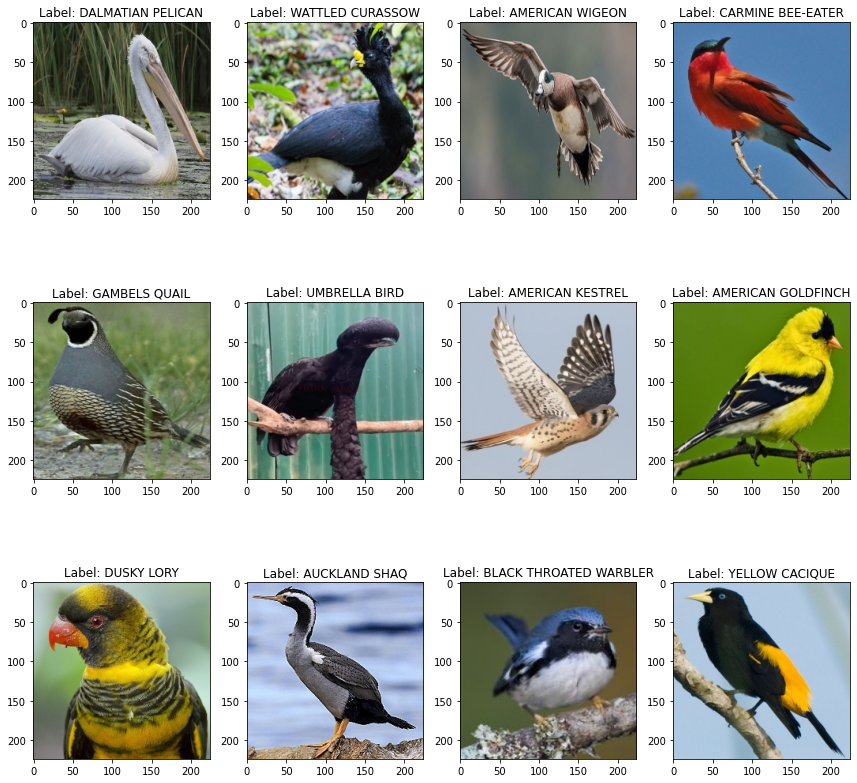

In [4]:
# Show few images from training data 
#  1 image per class can be shown 
# edit num_image to desired number of classes to be shown

dir = '../input/100-bird-species/train/'
dirnames = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
num_image = 12
num_row = 3
num_col = 4

# plot images

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,4*num_row))

for j,i in enumerate(dirnames[:num_image]):
    ax = axes[j//num_col, j%num_col]
    file = dir + i + '/'+ os.listdir(dir+i)[0]
    image = mpimg.imread(file)
    ax.imshow(image)
    ax.set_title('Label: {}'.format(i))
plt.tight_layout()
plt.show()

# Data preprocessing using ImageDataGenerator


In [5]:
# Data augmentation for training using ImageDataGenerator 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
                                                    '../input/100-bird-species/train',
                                                    target_size=(224,224),
                                                    batch_size= 64,
                                                    class_mode='categorical')

# Test data
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
                                                    '../input/100-bird-species/test',
                                                    target_size=(224,224),
                                                    batch_size= 64,
                                                    class_mode='categorical')

# Validation data
valid_datagen = ImageDataGenerator(rescale=1/255)
valid_generator = valid_datagen.flow_from_directory(
                                                    '../input/100-bird-species/valid',
                                                    target_size=(224,224),
                                                    batch_size= 64,
                                                    class_mode='categorical')


Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.


# Densenet model definition, training, evaluation

In [6]:
densenet_raw_model = tf.keras.applications.densenet.DenseNet121(
                                                            include_top=False,
                                                            weights='imagenet',
                                                            input_shape=(224,224,3), # input size of the images(fixed)
                                                            pooling='max')

# To not train these weights with our training images
for layers in densenet_raw_model.layers:
    layers.trainable=False

# append Dense layers to clssify it for number of classes for the given problem
num_of_classes = 450
densenet_model_output = densenet_raw_model.layers[-1].output
appended_layer = tf.keras.layers.Flatten()(densenet_model_output)
appended_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax')(appended_layer)


# final model
densenet_final_model = tf.keras.Model(densenet_raw_model.input, appended_layer)
print(densenet_final_model.summary())
densenet_final_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])

2022-12-15 04:22:52.076662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 04:22:52.222462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 04:22:52.223283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 04:22:52.224756: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [7]:
history = densenet_final_model.fit(
                                    train_generator,
                                    epochs=5,
                                    validation_data=valid_generator)


2022-12-15 04:22:58.437773: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-12-15 04:23:05.027975: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1104/1104 [==============================] - 428s 377ms/step - loss: 13.7923 - accuracy: 0.5003 - val_loss: 6.3158 - val_accuracy: 0.6978
Epoch 2/5
1104/1104 [==============================] - 249s 225ms/step - loss: 6.3351 - accuracy: 0.7187 - val_loss: 4.9905 - val_accuracy: 0.7778
Epoch 3/5
1104/1104 [==============================] - 239s 216ms/step - loss: 5.6822 - accuracy: 0.7759 - val_loss: 5.1694 - val_accuracy: 0.8098
Epoch 4/5
1104/1104 [==============================] - 246s 223ms/step - loss: 5.1512 - accuracy: 0.8132 - val_loss: 4.6474 - val_accuracy: 0.8369
Epoch 5/5
1104/1104 [==============================] - 253s 229ms/step - loss: 4.7398 - accuracy: 0.8361 - val_loss: 5.4490 - val_accuracy: 0.8364


In [8]:
densenet_final_model.evaluate(test_generator)

36/36 [==============================] - 13s 348ms/step - loss: 4.5860 - accuracy: 0.8547


[4.5860090255737305, 0.8546666502952576]

In [9]:
densenet_final_model.save('densenet_final_model.h5')